## Preprocessing

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [758]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

#  Import and read the charity_data.csv.
import pandas as pd
application_df = pd.read_csv("https://static.bc-edx.com/data/dl-1-2/m21/lms/starter/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [759]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(['EIN', 'NAME'], inplace= True, axis= 1)

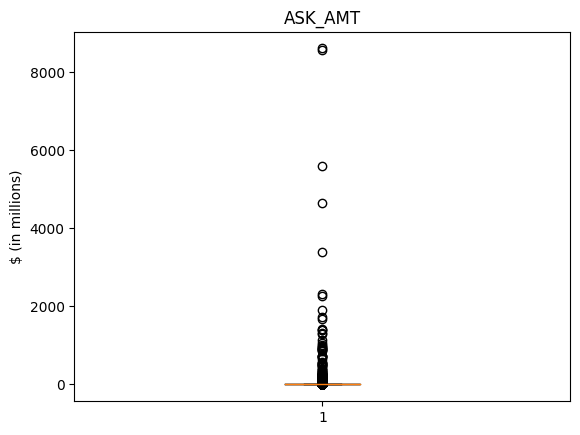

In [760]:
# Look for outliers in ASK_AMT
# Create a boxplot to visualize possible outliers
fig1, ax1 = plt.subplots()
ax1.set_title('ASK_AMT')
ax1.set_ylabel('$ (in millions)')
ax1.boxplot(application_df['ASK_AMT'] / 1000000)
plt.show()

In [761]:
# Determine which data points are outside of the 1.5*IQR range
quartiles = np.quantile(application_df['ASK_AMT'],[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)
potential_outliers = [i for i in application_df['ASK_AMT'] if i < lower_bound or i > upper_bound]

In [762]:
# Delete outliers
application_df = application_df[application_df['ASK_AMT'] < min(potential_outliers)]

In [763]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE           12
AFFILIATION                 6
CLASSIFICATION             65
USE_CASE                    5
ORGANIZATION                4
STATUS                      2
INCOME_AMT                  9
SPECIAL_CONSIDERATIONS      2
ASK_AMT                   656
IS_SUCCESSFUL               2
dtype: int64

In [764]:
# Look at APPLICATION_TYPE value counts to identify and replace with "Other"
application_type_count = application_df['APPLICATION_TYPE'].value_counts()
application_type_count

APPLICATION_TYPE
T3     20086
T4      1331
T19      999
T5       894
T6       882
T8       669
T7       633
T10      508
T13       54
T9        18
T12       13
T2         6
Name: count, dtype: int64

In [765]:
# Choose a cutoff value and create a list of application types to be replaced
# use the variable name `application_types_to_replace`
application_types_to_replace = application_type_count[application_type_count < 54].index.tolist()

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure replacement was successful
application_df['APPLICATION_TYPE'].value_counts()

APPLICATION_TYPE
T3       20086
T4        1331
T19        999
T5         894
T6         882
T8         669
T7         633
T10        508
T13         54
Other       37
Name: count, dtype: int64

In [766]:
# Look at CLASSIFICATION value counts to identify and replace with "Other"
classification_count = application_df['CLASSIFICATION'].value_counts()
classification_count

CLASSIFICATION
C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
         ...  
C1732        1
C1728        1
C4120        1
C1245        1
C2150        1
Name: count, Length: 65, dtype: int64

In [767]:
# You may find it helpful to look at CLASSIFICATION value counts >1
classification_count[classification_count > 1]

CLASSIFICATION
C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
C7000      546
C1700      223
C4000      129
C5000      106
C1270       89
C2700       75
C7100       62
C2800       61
C1280       46
C1300       42
C1230       35
C2300       28
C1240       28
C1400       27
C7200       20
C6000       14
C8000       13
C1250       13
C7120       11
C1278       10
C1237        9
C8200        9
C1238        9
C1235        9
C1500        7
C1720        6
C1257        5
C7210        5
C2400        4
C1600        4
C4100        4
C1260        3
C1800        3
C1267        2
C1246        2
C1256        2
C0           2
Name: count, dtype: int64

In [768]:
# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
classifications_to_replace = classification_count[classification_count < 546].index.tolist()

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Check to make sure replacement was successful
application_df['CLASSIFICATION'].value_counts()

CLASSIFICATION
C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
Other     1140
C7000      546
Name: count, dtype: int64

In [769]:
# Convert categorical data to numeric with `pd.get_dummies`
application_clean_df = pd.get_dummies(application_df)
application_clean_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T13,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,5000,0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
3,1,6692,1,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
5,1,5000,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
9,1,5000,0,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [770]:
# Split our preprocessed data into our features and target arrays
y = application_clean_df['IS_SUCCESSFUL'].values
X = application_clean_df.drop(['IS_SUCCESSFUL'], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [771]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create a method that creates a new Sequential model with hyperparameter options
def optimal(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['tanh', 'relu'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=100,
        max_value=130,
        step=5), activation=activation, input_dim=45))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 1)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=100,
            step=5),
            activation=activation))

    # Output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [ ]:
# Load tuner function
tuner = kt.Hyperband(
    optimal,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Reloading Tuner from ./untitled_project/tuner0.json


In [ ]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

In [ ]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 105, 'num_layers': 1, 'units_0': 16, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 86, 'num_layers': 2, 'units_0': 81, 'units_1': 21, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 120, 'num_layers': 1, 'units_0': 41, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


## Compile, Train and Evaluate the Model

In [772]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
nn = tf.keras.models.Sequential()

# Input layer
nn.add(tf.keras.layers.Dense(units=105, activation='tanh', input_dim=45))

# First hidden layer
nn.add(tf.keras.layers.Dense(units=16, activation='tanh'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 105)               4830      
                                                                 
 dense_79 (Dense)            (None, 16)                1696      
                                                                 
 dense_80 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6543 (25.56 KB)
Trainable params: 6543 (25.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [773]:
# Compile the model
nn.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [774]:
# Train the model
callback_path = 'model_weights.h5'
checkpoint_callback = ModelCheckpoint(callback_path, save_weights_only=True, save_freq='epoch', period=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=50, callbacks=[checkpoint_callback])

Epoch 1/50
612/612 [==============================] - 2s 2ms/step - loss: 0.5514 - accuracy: 0.7397
Epoch 2/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.7468
Epoch 3/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7484
Epoch 4/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5282 - accuracy: 0.7484
Epoch 5/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.7499
Epoch 6/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.7490
Epoch 7/50
612/612 [==============================] - 2s 3ms/step - loss: 0.5252 - accuracy: 0.7492
Epoch 8/50
612/612 [==============================] - 2s 4ms/step - loss: 0.5243 - accuracy: 0.7520
Epoch 9/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7512
Epoch 10/50
612/612 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7507

In [775]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

204/204 - 0s - loss: 0.5402 - accuracy: 0.7472 - 409ms/epoch - 2ms/step
Loss: 0.5402441620826721, Accuracy: 0.7472409605979919


In [776]:
# Export our model to HDF5 file
nn.save('model_weights_AlphabetSoupCharity_Optimization.h5')
files.download('model_weights_AlphabetSoupCharity_Optimization.h5')
nn.save('AlphabetSoupCharity_Optimization.h5')
files.download('AlphabetSoupCharity_Optimization.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>